# Shear profile fitting

This CLMassmod notebook examplifies how to go from simulation outputs to shear profile fitting and cluster mass reconstruction.

The test simulated cluster comes the MXXL simulation. 

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import sys
import readers.readMXXL as rm
import os

## Load in MXXL data with the specified reader and have first look at data

This will read in 
- convergence kappa map
- shear maps (gamma1, gamma2)
 


In [25]:
simreader = rm.MXXLSimReader()
path_to_mxxl = '/Users/combet/RECHERCHE/LSST/clmassmod_data/mxxl/'
#path_to_mxxl = '/sps/lsst/users/ccombet/clmassmod_data/mxxl/'
halo_name='halo_54_902_1'
#halo_name='halo_54_100_0'
path_to_sim = os.path.join(path_to_mxxl,halo_name)
loaded_catalog = simreader.load(path_to_sim)


Loading /Users/combet/RECHERCHE/LSST/clmassmod_data/mxxl/halo_54_902_1


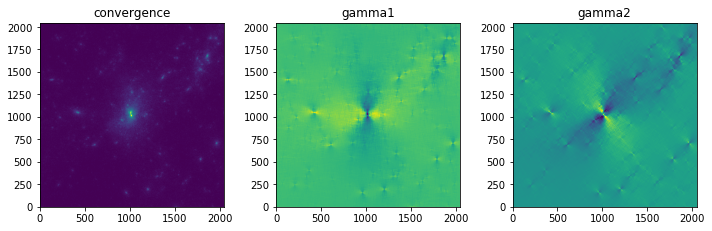

In [26]:
import numpy as np
reshape_size=int(np.sqrt(loaded_catalog.gamma1_inf.size))
gamma1_inf = loaded_catalog.gamma1_inf.reshape((reshape_size,reshape_size))
gamma2_inf = loaded_catalog.gamma2_inf.reshape((reshape_size,reshape_size))
kappa_inf = loaded_catalog.kappa_inf.reshape((reshape_size,reshape_size))

f, axes = plt.subplots(1, 3, figsize=(10,10))
axes[0].pcolormesh(kappa_inf)
axes[0].set_title('convergence')
axes[1].pcolormesh(gamma1_inf)
axes[1].set_title('gamma1')
axes[2].pcolormesh(gamma2_inf)
axes[2].set_title('gamma2')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
f.tight_layout()

### The .answer file provides the true mass as measured from the sim

In [27]:
m200_true = np.genfromtxt(path_to_sim+'.answer')[1]
print(m200_true)


1.00571045387e+15


## Build radial reduced shear profile from the simulation according to a given configuration 

* Configuration is given in `*config.py`. In particular this specifies
    - which `simreader` to use to read the simulation data. 
    - to include or not miscentering when building the shear profile
    - to include or not shear noise
    - the number of bins
    
    
* The shear radial profile is stored in `profile_of_sims_from_config`. 

In [28]:
import simutils

# ideal configuration
config = simutils.readConfiguration('idealsampleconfig.py')
simreader_from_configfile = config['simreader']
loaded_sim_from_config = simreader_from_configfile.load(path_to_sim)
profilebuilder_from_config = config['profilebuilder']
profile_of_sim_from_config0 = profilebuilder_from_config(loaded_sim_from_config)

# realistic configuration (including miscentering, shear noise)
config = simutils.readConfiguration('sampleconfig.py')
simreader_from_configfile = config['simreader']
loaded_sim_from_config = simreader_from_configfile.load(path_to_sim)
np.random.seed(0)
profilebuilder_from_config = config['profilebuilder']
profile_of_sim_from_config = profilebuilder_from_config(loaded_sim_from_config)



Loading /Users/combet/RECHERCHE/LSST/clmassmod_data/mxxl/halo_54_902_1
Center Offset: 0.0 0.0
Loading /Users/combet/RECHERCHE/LSST/clmassmod_data/mxxl/halo_54_902_1
Center Offset: 0.00973387182736 0.00264849667343


In [29]:
# These are the available fields
print profile_of_sim_from_config.table.keys()

['sigma_ghat', 'beta_s', 'ngals', 'r_mpc', 'ghat', 'beta_s2']


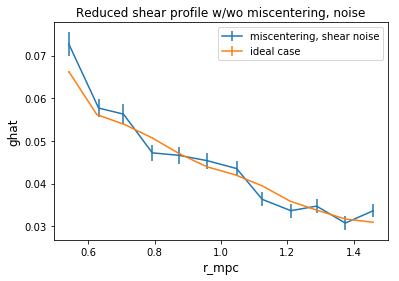

In [30]:
plt.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
                yerr=profile_of_sim_from_config.table['sigma_ghat'], label='miscentering, shear noise')
plt.errorbar(profile_of_sim_from_config0.table['r_mpc'], profile_of_sim_from_config0.table['ghat'], 
                yerr=profile_of_sim_from_config0.table['sigma_ghat'], label='ideal case')
plt.title('Reduced shear profile w/wo miscentering, noise')
plt.xlabel('r_mpc',fontsize='large')
plt.ylabel('ghat',fontsize='large')
plt.legend()

## First,  let's fit the above reduced shear profile using MLE

### First define the model to be fitted to the data - `model_reduced_shear`. Fit parameters are mass and concentration.


In [31]:
def model_reduced_shear( const_args, mass15, cdelta ) :
    from nfwmodeltools import NFWKappa, NFWShear
    import numpy as np
    
    mass = mass15 * 1e15
    (r, avg_beta, avg_beta2, rho_c, rho_c_over_sigma_c, delta) = const_args
    
    rdelta =(3*abs(mass)/(4*delta*np.pi*rho_c))**(1./3.)
    rscale = rdelta / cdelta
    kappa_inf = NFWKappa(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    gamma_inf = NFWShear(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    
    return avg_beta * gamma_inf / (1 - kappa_inf * avg_beta2/avg_beta)


### Prepare the data arrays for the fit


In [32]:
from nfwutils import global_cosmology

def get_data_for_MLE_fit(profile):
    avg_beta = profile.table['beta_s']
    avg_beta2 = profile.table['beta_s2']
    zcluster = profile.zcluster

    rho_c = global_cosmology.rho_crit(zcluster)
    # note: global_cosmology.beta([1e6], zcluster) is beta at effectively infinite redshift
    rho_c_over_sigma_c = 1.5 * global_cosmology.angulardist(zcluster) * \
        global_cosmology.beta([1e6], zcluster)[0] * global_cosmology.hubble2(zcluster) / \
        global_cosmology.v_c**2
    
    delta=200

    x_data = (profile.table['r_mpc'], 
              avg_beta, avg_beta2, rho_c, rho_c_over_sigma_c, delta)
    y_data = profile.table['ghat']
    sigma = profile.table['sigma_ghat']
    return x_data, y_data, sigma

In [33]:
x_data, y_data, sigma = get_data_for_MLE_fit(profile_of_sim_from_config)
x_data0, y_data0, sigma0 = get_data_for_MLE_fit(profile_of_sim_from_config0)

### Fit using `scipy.optimize.curve_fit`

In [34]:
# Let's fit the ideal and realistic cases
from scipy.optimize import curve_fit
popt0, pcov0 = curve_fit(model_reduced_shear, x_data0, y_data0, sigma=sigma0)
popt, pcov = curve_fit(model_reduced_shear, x_data, y_data, sigma=sigma)

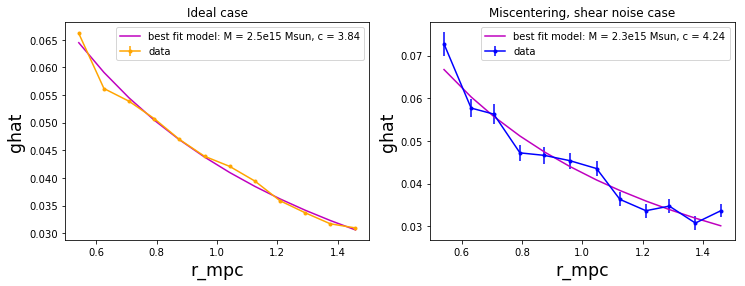

In [35]:
label0_str = 'best fit model: M = '+"{:2.1f}".format(popt0[0])+'e15 Msun, c = '+"{:2.2f}".format(popt0[1])
label_str = 'best fit model: M = '+"{:2.1f}".format(popt[0])+'e15 Msun, c = '+"{:2.2f}".format(popt[1])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].plot(profile_of_sim_from_config0.table['r_mpc'], model_reduced_shear( x_data0, *popt0 ), label=label0_str, 
             color='m')
axes[0].errorbar(profile_of_sim_from_config0.table['r_mpc'], profile_of_sim_from_config0.table['ghat'], 
            yerr=profile_of_sim_from_config0.table['sigma_ghat'], label='data', color='orange', marker='.')
axes[0].set_xlabel('r_mpc',fontsize='xx-large')
axes[0].set_ylabel('ghat',fontsize='xx-large')
axes[0].set_title('Ideal case')
axes[0].legend()
axes[1].plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear( x_data, *popt ), label = label_str,
            color='m')
axes[1].errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'], label='data', color='blue', marker='.')
axes[1].set_xlabel('r_mpc',fontsize='xx-large')
axes[1].set_ylabel('ghat',fontsize='xx-large')
axes[1].set_title('Miscentering, shear noise case')
axes[1].legend()


## Now, let's move to the Bayesian approach, using `pymc` 

In [36]:
# Let's create a directed acyclic graph: Baysian Network to do the analog to curve_fit
# with pymc, taking into account prior distributions.
import pymc
mass15 = pymc.Uniform('mass15',0.01, 150)
concentration = pymc.Uniform('concentration',1., 15.)

@pymc.deterministic(trace=False)  # Applies to gmodel in the next line
def gmodel(x_data=x_data, mass15=mass15, concentration=concentration) :
    return model_reduced_shear(x_data, mass15, concentration)

gsigma = sigma  # This *could* be a probability distribution
tau = 1./gsigma**2
#@pymc.observed <---- this is needed if the next line is a function 
# that calculates likelihood and returns the log probability

gobserved = pymc.Normal('gobserved', mu=gmodel, tau=tau, value=y_data, observed=True)

In [37]:
mass15.value = 1.
concentration.value = 1.3
print model_reduced_shear(x_data, mass15.value, concentration.value)

[ 0.02028137  0.01939078  0.01869152  0.01792552  0.01725588  0.01659953
  0.01594202  0.01540561  0.01483748  0.01435586  0.01384708  0.01337852]


In [38]:
# Let's create a pymc model object from the nodes of the graph
pymc_model = pymc.Model([mass15, concentration, gmodel, gobserved])

In [39]:
# Print initial values
print mass15.value, concentration.value

1.0 1.3


In [40]:
# Print log probability of the Bayesian network
print mass15.logp
print gobserved.logp
print gobserved.observed
print gobserved.parent_names

-5.01056862521
-1234.25382466
True
['mu', 'tau']


In [41]:
# We can manually change the values and see how the log prob changes (e.g. more reasonable mass, and larger logp) 
mass15.value = 1.e-2
print pymc_model.logp
print gobserved.logp

-3039.35500788
-3031.70538192


In [42]:
# We can find parameters that maximize log prob of the network
pymc_maximum_aposteriori = pymc.MAP(pymc_model)
pymc_maximum_aposteriori.fit()
print mass15.value, concentration.value
print gmodel.value

2.31755803568 4.24074996275
[ 0.06673206  0.06031788  0.05575352  0.05115772  0.04744243  0.04404279
  0.04085261  0.03839521  0.03592303  0.03392498  0.0319052   0.03012274]


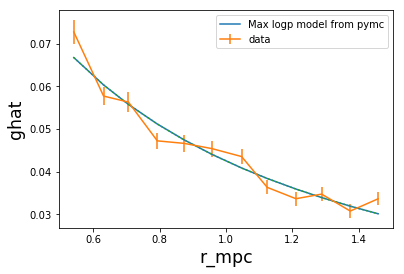

In [43]:
# Let's compare with the data

plt.plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear(x_data, mass15.value, concentration.value),
         label='Max logp model from pymc')
plt.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'], label='data')
plt.plot(profile_of_sim_from_config.table['r_mpc'], gmodel.value, ls=":")
plt.xlabel('r_mpc',fontsize='xx-large')
plt.ylabel('ghat',fontsize='xx-large')
plt.legend()

### Now use `pymc.MCMC` to sample the posterior distribution of the parameters. 

In [32]:
#  Let's now explore the full posterior without making any normal approximations, etc.
pymc_MCMC = pymc.MCMC(pymc_model)
# Let's run for 1000 iterations
pymc_MCMC.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

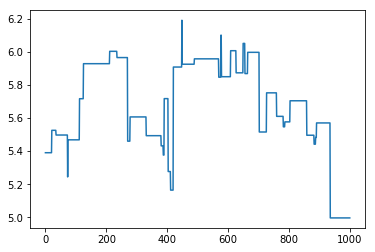

In [33]:
# We want to plot a value vs. steps in chain.  Note -this has not yet converged
plt.plot(pymc_MCMC.trace('mass15')[:])

In [34]:
# Let's run for longer now
pymc_MCMC.sample(100000)


 [-----------------100%-----------------] 100000 of 100000 complete in 14.9 sec

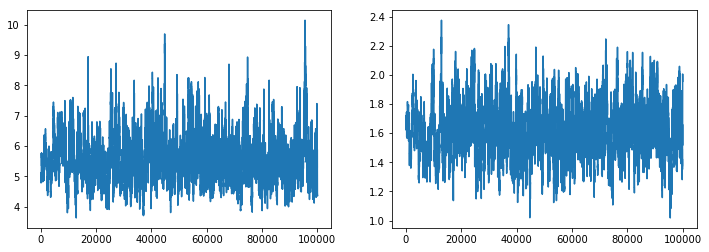

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(pymc_MCMC.trace('mass15')[:])
axes[1].plot(pymc_MCMC.trace('concentration')[:])


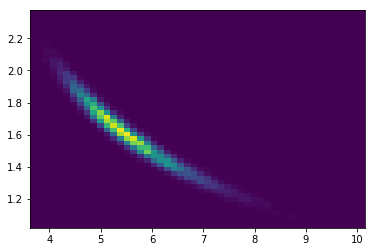

In [36]:
#  We are now plotting P(M, c | ghat )
hist = plt.hist2d(pymc_MCMC.trace('mass15')[:], pymc_MCMC.trace('concentration')[:], bins=50)

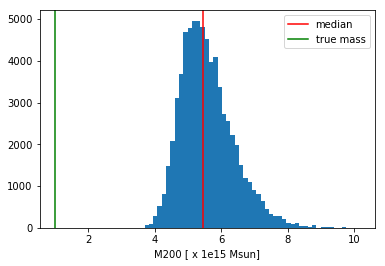

In [54]:
hist = plt.hist(pymc_MCMC.trace('mass15')[30000:], bins=50)
plt.axvline(np.median(pymc_MCMC.trace('mass15')[30000:]), c='r', label='median')
plt.axvline(m200_true/1.e15, c='g', label='true mass')
plt.xlabel('M200 [ x 1e15 Msun]')
plt.legend()


In [55]:
print "Median mass from posterior = ",np.median(mass15.trace())*1.e15,"Msun" 

Median mass from posterior =  5.46396897866e+15 Msun


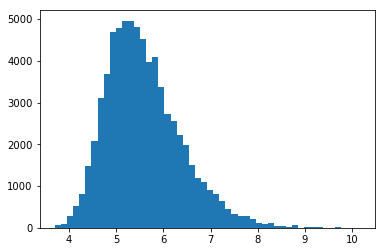

In [56]:
hist = plt.hist(mass15.trace()[30000:], bins=50)

In [227]:
import pymc
bob = pymc.Uniform('bob',0.01, 150)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  1000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([ 81.82653745,  81.83653745,  81.84653745,  81.85653745,
         81.86653745,  81.8765

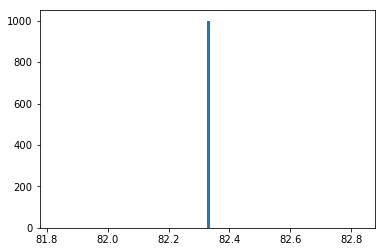